In [1]:
import argparse
import json
import textwrap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from reticuler.system import System
from reticuler.backward_evolution.system_back import BackwardSystem
from reticuler.user_interface import graphics

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "figure.dpi": 150,
        "text.usetex": True,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "axes.linewidth": 0.5,
        "axes.titlesize": 12,
        "axes.labelsize": 8,
        "lines.linewidth": 1,
        "lines.markersize": 1,
        "lines.marker": "None",
        "lines.solid_capstyle": "round",
        "font.family": "serif",
        "font.serif": ["Computer Modern"],  # ['Times New Roman']
    }
)
# 'font.size': 20,
# 'font.family': 'serif',
# 'font.serif': ['Times New Roman']})
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
cm2inch = 1 / 2.54
golden = (1 + 5**0.5) / 2

# Matlab

In [3]:
def integerise(x):
    """Convert x to string without dot if it is an integer ('2.' -> '2')."""
    
    if np.isclose(x, round(x), atol=1e-3 ):
        return '{:.0f}'.format(x)
    else:
        return '{}'.format(x) # '{:.1f}'.format(x)

def import_msh(file_name):
    """
    Import file '.msh' (as explained in the FreeFEM++ documentation - https://doc.freefem.org/documentation/mesh-generation.html#format-of-mesh-data):
     - heading: number of vertices, number of triangles, number of edges on boundary
     - vertices: x, y, boundary label
     - triangles: index1, index2, index3, region label
     - edges: index1, index2, boundary label

    Parameters
    -------
    file_name : string
    
    Returns
    -------
    np.array
        A 3-n array of points on the boundary.
    np.array
        A 4-n array of triangles composing the mesh.
    np.array
        A 3-n array of edges composing the boundary.    
    """
    
    heading = np.loadtxt(file_name, max_rows=1, dtype=int)
    vertices_mesh = np.loadtxt(file_name, skiprows=1, max_rows=heading[0])
    triangles_mesh = np.loadtxt(file_name, skiprows=1+heading[0], max_rows=heading[1], dtype=int)
    edges_mesh = np.loadtxt(file_name, skiprows=1+heading[0]+heading[1], dtype=int)
    return vertices_mesh, triangles_mesh, edges_mesh

def extract_branches(vertices_mesh, edges_mesh, network_seeds):
    """
    Construct branches of the network from mesh edges.
    
    Parameters
    -------
    vertices_mesh : np.array
        A list of points composing the network.
    edges_mesh : np.array
        A list of edges composing the network.
    seed : list
        A list of indices in the list of points marking where the network starts.
    
    Returns
    -------
    np.array
        A list of 2-n arrays containing xy coordinates of points composing the branch.  
    """
    branches=[]
    while len(network_seeds)>0:
        seed_tmp=[network_seeds[0]]
        long_line = [edges_mesh[edges_mesh[:,1]==seed_tmp,0][0]]
        while len(seed_tmp)==1:
            long_line.append(seed_tmp[0])
            seed_tmp=edges_mesh[edges_mesh[:,0]==long_line[-1],1]
        network_seeds=np.append(network_seeds,seed_tmp)
        network_seeds=network_seeds[1:]
        branches.append(vertices_mesh[np.asarray(long_line)-1])
    return branches

def plot_tree(ax, file_name, height=2.0, width=2.0, **kwargs_tree_plot):
    """
    Plot a tree with optional arguments from **kwargs_tree and black box.    
    
    Parameters
    -------
    ax : Axes 
        Object to plot on.
    branches : list
        A list of branch arrays containing xy coordinates of the branch.
    height : float, default 2.0
        y limit to plot.
    kwargs_plots : dict, default {}
        Arguments to plot the tree.
    
    Returns
    -------
    none
    """
    options_tree_plot = {'color': '#0066CC', 'linewidth': 0.8}
    options_tree_plot.update(kwargs_tree_plot)
    
    box_indices = np.array([1, 2, 3, 4, 5, 1])
    
    [vertices_mesh, triangles_mesh, edges_mesh] = import_msh(file_name)
    branches = extract_branches(vertices_mesh, edges_mesh, network_seeds=[6])
    box = vertices_mesh[box_indices-1]
    
    # PLOT LINES
    for line in branches:
        ax.plot(line[:,0], line[:,1], **options_tree_plot)
    # PLOT BOX
    ax.plot(box[:,0], box[:,1], linewidth=options_tree_plot['linewidth']*2, color='0')
        
    ax.axis('off')
    # colouring background 
    ax.add_artist(ax.patch)
    ax.patch.set_zorder(-1)
    ax.set_facecolor('#def1ff')
    ax.set_aspect('equal')
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)

# Reticuler vs Matlab

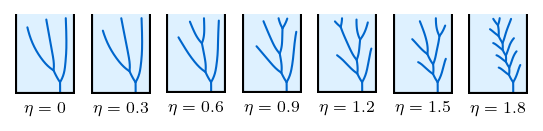

In [4]:
fig = plt.figure(figsize=(17.8*cm2inch,7.05*cm2inch))
gs = GridSpec(nrows=2, ncols=9, width_ratios=[1]*7 + [2.25]*2)# , height_ratios=[4, 1])

# archive_name = 'g:/My drive/Archive/Numerical/Rivers_MATLAB'
folder_name = 'g:/My drive/Research/Network simulations/reticuler/'
folder_name = folder_name + 'archive/growth/testing/test_1.0/matlab_comparison/laplace_freefem2_v5/'
# folder_name = 'growth/archive/test/lap/'
eta_range = np.around(np.arange(7)*0.3,1)
for i, eta in enumerate(eta_range):
    ax = fig.add_subplot(gs[:,i])
    system = System.import_json(input_file='{}eta{:02d}'.format(folder_name, int(eta*10)))
    graphics.plot_tree( ax, network=system.network, linewidth=1)
    ax.set_title(r'$\eta = '+ integerise(eta)+'$', fontsize=8, y=-0.4)
# fig.savefig('lap.pdf', bbox_inches='tight')

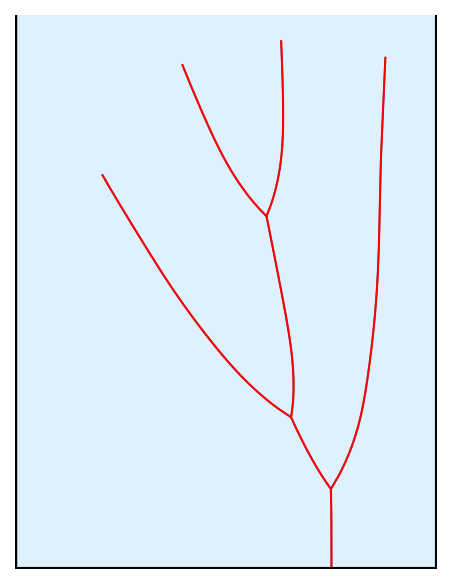

In [5]:
eta = 0.6
fig, ax = plt.subplots()

# archive_name = 'g:/My drive/Archive/Numerical/Rivers_MATLAB'
folder_name = 'g:/My drive/Research/Network simulations/reticuler/misc/matlab/'
folder_name = folder_name + 'archive/growth/test/laplace_freefem2_v5/'
plot_tree(ax, file_name='{}eta{}.msh'.format(folder_name, integerise(eta*10)), height=2.5*1.05)


folder_name = 'g:/My drive/Research/Network simulations/reticuler/'
folder_name = folder_name + 'archive/growth/testing/test_1.0/matlab_comparison/laplace_freefem2_v5/'
system = System.import_json(input_file='{}eta{:02d}'.format(folder_name, int(eta*10)))
graphics.plot_tree( ax, network=system.network, linewidth=1, color='red', linestyle='-')

# Reticuler BEA

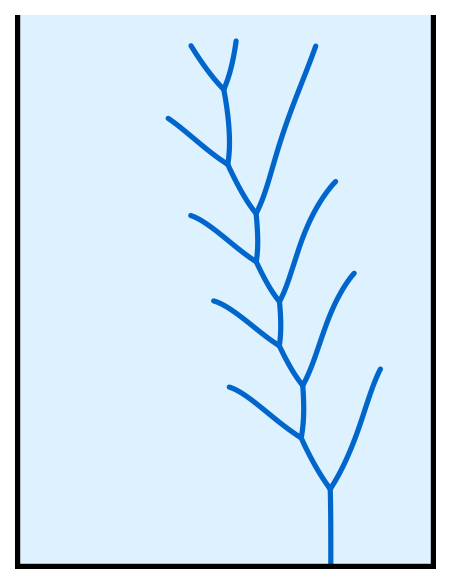

In [7]:
archive_name = 'g:/My drive/Research/Network simulations/reticuler/'
exp_name = archive_name + 'archive/BEA/testing/test_1.0/matlab_comparison/laplace_freefem2_v5/eta_original18/'
input_file = [exp_name+"original_tree"]

# Import System from JSON file
system = System.import_json(input_file=input_file[0])

fig, ax = plt.subplots()
graphics.plot_tree( ax, network=system.network)

In [8]:
def calculate_quantiles(data, q=0.25):
    """
    Calculate quantiles and width of a given data.
    
    Parameters
    -------
    data : np.array 
            
    Returns
    -------
    np.array
        A 1-7 array with:
        - quantiles of data of order 50%, q, 1-q
        - quantiles of abs(data) of order 50%, q, 1-q
        - width: (quant. of order q) - (quantiles of order 1-q)
        [q50, q32, q68, q50(abs), q32(abs), q68(abs), width]
        
    """
    q32 = np.quantile(data, q)
    q50 = np.quantile(data, 0.5)
    q68 = np.quantile(data, 1-q)
    q32_abs = np.quantile(abs(data), q)
    q50_abs = np.quantile(abs(data), 0.5)
    q68_abs = np.quantile(abs(data), 1-q)
    width = q68 - q32
    return np.array([q50, q32, q68, q50_abs, q32_abs, q68_abs, width])


def gather_results(eta_range, folder_name, stream_min=0, stream_max=1e5, step_min=0, step_max=1e5, q=0.25):
    """
    Gathering results from backward evolution with filtering set by stream/step min/max. Filtering done with less/greater-equal (<= or >=).

    Parameters
    -------
    eta_range : array
        An array of eta for which we gather data.
    folder_name : string
        A directory from which results will be gathered.
    stream_min : int, default=0
        Minimum stream index to be analysed.
    stream_max : int, default=1e5
        Maximum stream index to be analysed. 
    step_min : int, default=0
        Maximum step in backward evolution (on one branch) to be analysed.
    step_max : int, defult=1e5
        Maximum step in backward evolution (on one branch) to be analysed.
    
    Returns
    -------
    np.array
        A 3-len(eta_range)-7 array of results calculated in 'calculate_quantiles' including:
            - geometric deviation metric
            - angular deviation metric
            - local symmetry metric 
    ( Above len(eta_range)-7 subarrays compose of columns:  q50, q32, q68, q50(abs), q32(abs), q68(abs), width )
    """    

    results = np.empty((3, eta_range.shape[0], 7))
    
    for i, eta in enumerate(eta_range): 
        streams, steps_back = np.loadtxt('{}{}{}.txt/'.format(folder_name, file_backward, integerise(eta*10)), \
                                         usecols=(stream_column, step_column), delimiter=',', dtype='int', unpack=True)
        filter_data = (stream_min<=streams) & (streams<=stream_max) & (step_min<=steps_back) & (steps_back<=step_max)

        a1, a2, a3, geo, ang = np.loadtxt('{}{}{}.txt/'.format(folder_name, file_backward, integerise(eta*10)), \
                                          usecols=(a1_column, a2_column, a3_column, geo_dev_column, ang_dev_column), \
                                          delimiter=',', unpack=True)[:,filter_data]

        results[0, i,:] = calculate_quantiles(a2/a1**2, q)
        results[1, i,:] = calculate_quantiles(geo, q)
        results[2, i,:] = calculate_quantiles(ang, q)
    
    return results

In [12]:
b_b.a1a2a3_coefficients

array([], dtype=float64)

In [15]:
eta_original = 1.8
# folder_name=folder_name+"eta_original{eta:02d}/".format(eta=int(eta_original*10))
eta_min=0
eta_max=30
eta_range = np.arange(eta_min,eta_max+1)/10

q = 0.25

results = np.empty((3, eta_range.shape[0], 7))
results_bif = np.empty((3, eta_range.shape[0],7))
for i, eta in enumerate(eta_range):
    # Branches
    system = System.import_json(input_file=exp_name+"original_tree")
    file_name = exp_name+"eta{eta:02d}_back".format(eta=int(eta*10))
    backward_system = BackwardSystem.import_json(input_file=file_name, system=system)
    
    a1a2a3_coefficients = np.empty((0,3), dtype=float)
    overshoot = []
    angular_deflection = []
    for b_b in backward_system.backward_branches[1:]:
        if len(b_b.steps)>0:
            a1a2a3_coefficients = np.vstack((a1a2a3_coefficients, b_b.a1a2a3_coefficients))
            overshoot = np.append(overshoot, b_b.overshoot)
            angular_deflection = np.append(angular_deflection, b_b.angular_deflection)

    results[0, i,:] = calculate_quantiles(a1a2a3_coefficients[:,1]/a1a2a3_coefficients[:,0]**2, q)
    results[1, i,:] = calculate_quantiles(overshoot, q)
    results[2, i,:] = calculate_quantiles(angular_deflection, q)
    
    # Bifurcations
    mask = backward_system.backward_bifurcations.flags==3
    a1a2a3_coefficients_bif = backward_system.backward_bifurcations.a1a2a3_coefficients[mask,...]
    length_mismatch =backward_system.backward_bifurcations.length_mismatch[mask]
    results_bif[0, i,:] = calculate_quantiles(length_mismatch)
    results_bif[1, i,:] = calculate_quantiles(a1a2a3_coefficients_bif[:,0])
    results_bif[2, i,:] = calculate_quantiles(a1a2a3_coefficients_bif[:,2]/a1a2a3_coefficients_bif[:,0])

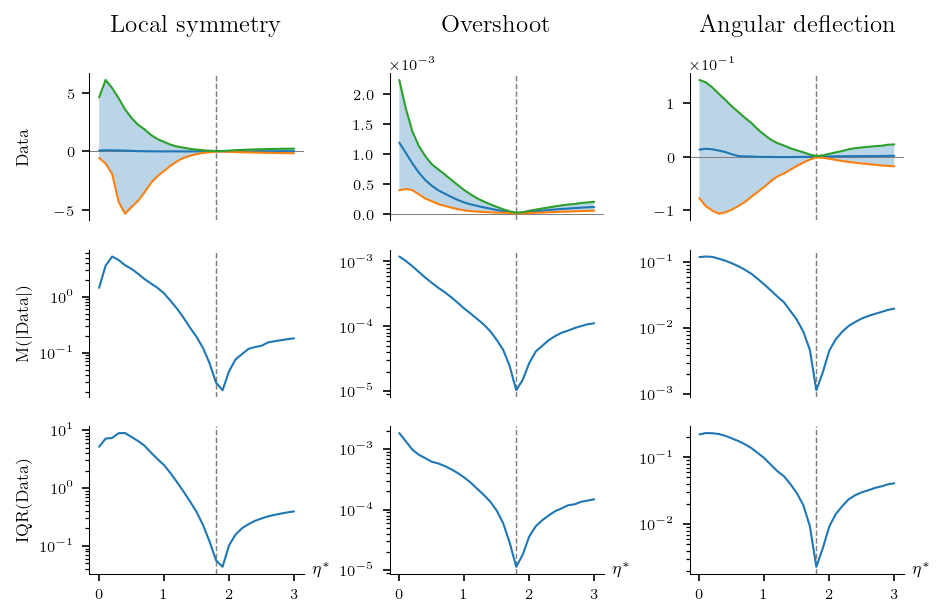

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17.8*cm2inch,17.8/golden*cm2inch)) # 17.8/golden
fig.subplots_adjust(wspace=0.4)
# titles on top
titles = ['Local symmetry', 'Overshoot', 'Angular deflection']
# labels on the left
axes[0, 0].set_ylabel('Data')# , labelpad=24) # labelpad: 35.5/10; 2nd line # 29.5/10 # 17.5/0
axes[1, 0].set_ylabel('M($|$Data$|$)')# , labelpad=10)
axes[2, 0].set_ylabel('IQR(Data)') # , labelpad=10)
for i, measure_results in enumerate(results):
    # plot DATA
    axes[0, i].axvline(x=eta_original, color='0.5', linewidth=0.7, linestyle='--')
    axes[0, i].axhline(y=0, color='0.5', linewidth=0.5)
    axes[0, i].plot(eta_range,measure_results[:,0:3],label=['Median', 'Quantile 32\%', 'Quantile 68\%'])
    axes[0, i].fill_between(eta_range,measure_results[:,1],measure_results[:,2], alpha=0.3)
    # ticks, frame, title
    axes[0, i].spines['top'].set_visible(False)
    axes[0, i].spines['right'].set_visible(False)
    axes[0, i].spines['bottom'].set_visible(False)
    axes[0, i].xaxis.set_visible(False)
    axes[0, i].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    axes[0, i].set_title(titles[i], y=1.2) # (r'\textbf{'+titles[i]+'}', y=1.2)

    # plot DATA (log)
    axes[1, i].axvline(x=eta_original, color='0.5', linewidth=0.7, linestyle='--')
    axes[1, i].plot(eta_range,measure_results[:,3])
    # ticks, frame
    axes[1, i].set_yscale('log')
    axes[1, i].spines['top'].set_visible(False)
    axes[1, i].spines['right'].set_visible(False)
    axes[1, i].spines['bottom'].set_visible(False)
    axes[1, i].xaxis.set_visible(False)

    # plot WIDTH (log)
    axes[2, i].axvline(x=eta_original, color='0.5', linewidth=0.7, linestyle='--')
    axes[2, i].plot(eta_range, measure_results[:,6])
    axes[2, i].set_yscale('log')
    # ticks, frame
    axes[2, i].spines['top'].set_visible(False)
    axes[2, i].spines['right'].set_visible(False)
    # axes[2, i].set_xlabel('$\eta^*$', position=(1.08,0), labelpad=-18)
    axes[2, i].set_xlabel('$\eta^*$')
    axes[2, i].xaxis.set_label_coords(1.08, 0.08)
fig.align_ylabels()
fig.savefig(exp_name+'backward_results_lap_v2_reticuler.pdf', bbox_inches='tight') 

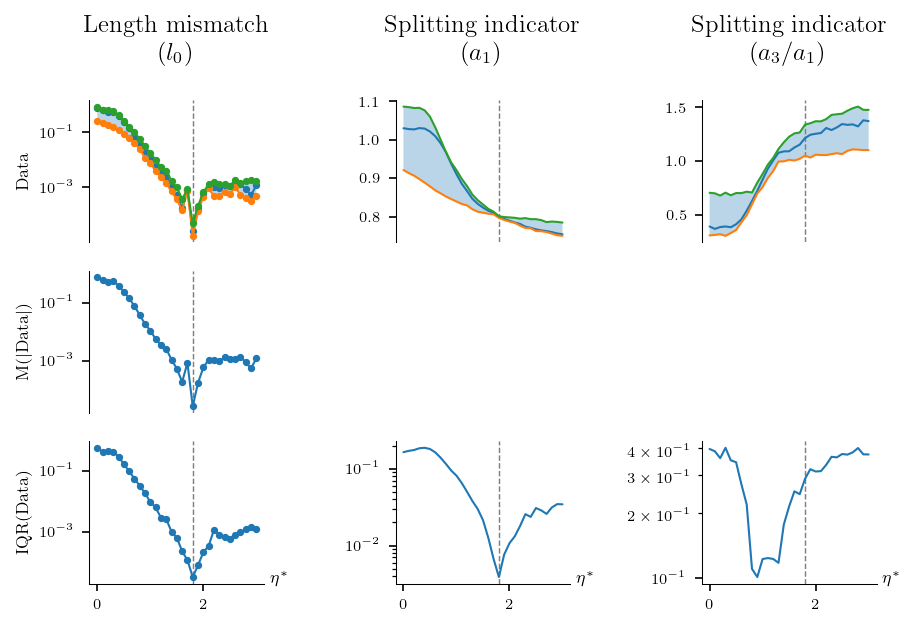

In [19]:
figurewidth=17.2
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(figurewidth*cm2inch,figurewidth/golden*cm2inch)) # 17.8/golden
fig.subplots_adjust(wspace=0.75)
titles = ['Length mismatch\n($l_0$)', 'Splitting indicator\n($a_1$)', 'Splitting indicator\n($a_3/a_1$)']
# FIRST ROW
for i, ax in enumerate(axes[0,:]):
    ax.axvline(x=eta_original, color='0.5', linewidth=0.7, linestyle='--')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_title(titles[i], y=1.2)
# SECOND ROW
for ax in axes[1,:]:
    ax.axvline(x=eta_original, color='0.5', linewidth=0.7, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)

# THIRD ROW
for ax in axes[2,:]:
    ax.axvline(x=eta_original, color='0.5', linewidth=0.7, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('$\eta^*$')
    ax.xaxis.set_label_coords(1.08, 0.08)   
    
# LENGTH MISMATCH QUANTILES
axes[0, 0].axhline(y=0, color='0.2', linewidth=0.5)
axes[0, 0].plot(eta_range, results_bif[0][:,0:3], '.-', ms=5)
axes[0, 0].fill_between(eta_range, results_bif[0][:,1], results_bif[0][:,2], alpha=0.3)
axes[0, 0].set_ylabel('Data')
axes[0, 0].set_yscale('log')
# LENGTH MISMATCH WIDTH
axes[1, 0].plot(eta_range, results_bif[0][:,3], '.-', ms=5)
axes[1, 0].set_yscale('log')
axes[1, 0].set_ylabel('M($|$Data$|$)')
# LENGTH MISMATCH WIDTH
axes[2, 0].plot(eta_range, results_bif[0][:,6], '.-', ms=5)
axes[2, 0].set_yscale('log')
axes[2, 0].set_ylabel('IQR(Data)')

# BIFURCATION QUANTILES
# axes[0, 1].axhline(y=bif_value, color='0.5', linewidth=0.5)
axes[0, 1].plot(eta_range, results_bif[1][:,0:3], label=['Median', 'Quantile 32\%', 'Quantile 68\%'])
axes[0, 1].fill_between(eta_range, results_bif[1][:,1], results_bif[1][:,2], alpha=0.3)
# BIFURCATION LOG
axes[1,1].yaxis.set_visible(False)
axes[1,1].spines['left'].set_visible(False)
axes[1,1].lines.pop(0)
# axes[1, 1].plot(eta_range, results_bif[1][:,3])
# axes[1, 1].set_yscale('log')
# BIFURCATION WIDTH
axes[2, 1].plot(eta_range, results_bif[1][:,6])
axes[2, 1].set_yscale('log')

# BIFURCATION QUANTILES
# axes[0, 1].axhline(y=bif_value, color='0.5', linewidth=0.5)
axes[0, 2].plot(eta_range, results_bif[2][:,0:3], label=['Median', 'Quantile 32\%', 'Quantile 68\%'])
axes[0, 2].fill_between(eta_range, results_bif[2][:,1], results_bif[2][:,2], alpha=0.3)
# BIFURCATION LOG
axes[1,2].yaxis.set_visible(False)
axes[1,2].spines['left'].set_visible(False)
axes[1,2].lines.pop(0)
# axes[1, 2].plot(eta_range, results_bif[2][:,3])
# axes[1, 2].set_yscale('log')
# BIFURCATION WIDTH
axes[2, 2].plot(eta_range, results_bif[2][:,6])
axes[2, 2].set_yscale('log')

fig.align_ylabels()
fig.savefig(exp_name+'backward_results_lap_bifs_reticuler.pdf', bbox_inches='tight')